# Final ITCS 3156 Project: Predicting EEG Channels correlation with Eye State

In [15]:
from typing import List, Dict, Tuple, Callable
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

## Loading the EEG EYE STATE Dataset

In [16]:
#installs the ucimlrepo if it is not installed yet
#!pip install ucimlrepo

In [17]:
#I got this Roesler dataset on how to import it
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
eeg_eye_state = fetch_ucirepo(id=264) 

# data (as pandas dataframes) 
X = eeg_eye_state.data.features 
y = eeg_eye_state.data.targets 
  
# metadata 
print(eeg_eye_state.metadata) 
  
# variable information 
print(eeg_eye_state.variables) 

eye_state_df = pd.concat([X, y], axis=1)
print(type(eye_state_df))
print(eye_state_df.head())
print("Shape: ",eye_state_df.shape)
print(eye_state_df['eyeDetection'].value_counts())


# save as a CSV file
#eye_state_df.to_csv("EEG_Eye_State.csv", index=False)

{'uci_id': 264, 'name': 'EEG Eye State', 'repository_url': 'https://archive.ics.uci.edu/dataset/264/eeg+eye+state', 'data_url': 'https://archive.ics.uci.edu/static/public/264/data.csv', 'abstract': 'The data set consists of 14 EEG values and a value indicating the eye state.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 14980, 'num_features': 14, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['eyeDetection'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Thu Mar 21 2024', 'dataset_doi': '10.24432/C57G7J', 'creators': ['Oliver Roesler'], 'intro_paper': None, 'additional_info': {'summary': "All data is from one continuous EEG measurement with the Emotiv EEG Neuroheadset. The duration of the measurement was 117 seconds. The eye state was detected via a camera during the EEG measuremen

## Plotting

In [18]:
def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_names: Dict[int, str] = None,
    figsize: Tuple = (10, 5)
) -> pd.DataFrame:
    """ Plots a pretty and labeld version of Sklerarn's confusion matrix

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

            class_names: Dictionary mapping labels to class names.

                Example: {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

            figsize: A tuple for setting the width and height of the plot.

        Returns:
            A confusion matrix casted as a DataFrame
    """
    y =  y.flatten() # reshape to make 1D vector for consistency
    y_hat = y_hat.flatten() # reshape to make 1D vector for consistency
    
    cfm = confusion_matrix(y_true=y, y_pred=y_hat)    
    
    labels = np.sort(np.unique(y))
    if class_names is not None:
        classes = []
        for l in labels:
            class_name = class_names.get(l, l)
            classes.append(class_name)
        labels = classes
        
    columns, index = labels, labels
    fig, ax = plt.subplots(figsize=figsize)  
    cfm_df = pd.DataFrame(cfm, index=index, columns=columns)
    sns.heatmap(cfm_df, annot=True, fmt='g', ax=ax)
    plt.show()
    return cfm_df

## Data Visualization

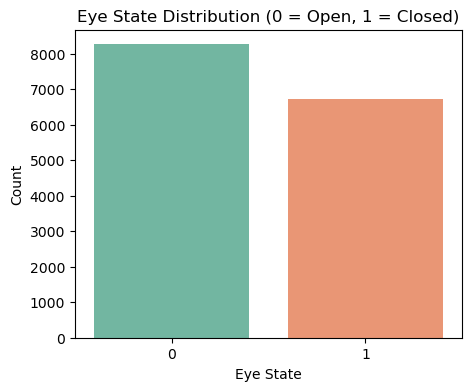

In [19]:
#Shows the total open and closed states
plt.figure(figsize=(5,4))
sns.countplot(data=eye_state_df, x='eyeDetection', hue='eyeDetection', palette='Set2', legend=False)
plt.title('Eye State Distribution (0 = Open, 1 = Closed)')
plt.xlabel('Eye State')
plt.ylabel('Count')
plt.show()

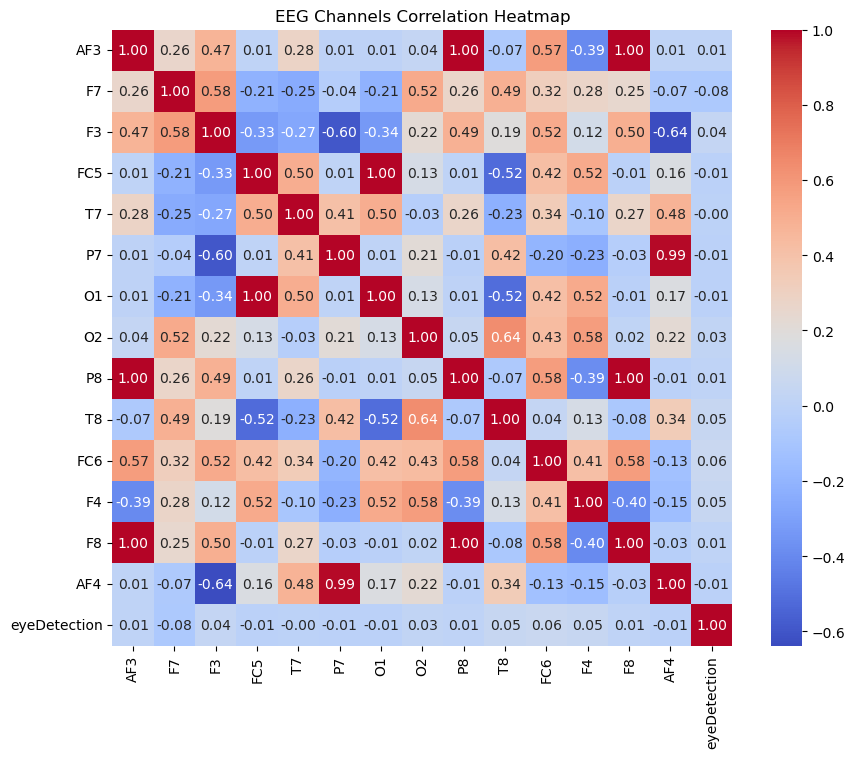

In [20]:
#shows which EEG channels are correlated
plt.figure(figsize=(10,8))
corr = eye_state_df.corr()
sns.heatmap(corr,annot=True, fmt='.2f', cmap='coolwarm')
plt.title('EEG Channels Correlation Heatmap')
plt.show()

<Figure size 1600x600 with 0 Axes>

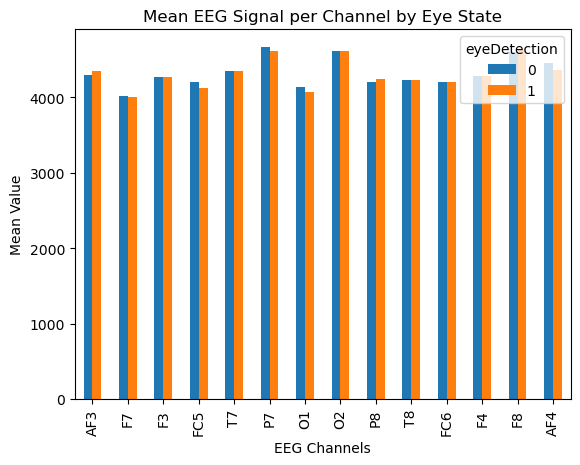

In [21]:
# Compute mean per channel for each class
mean_by_class = eye_state_df.groupby("eyeDetection").mean().T

plt.figure(figsize=(16,6))
mean_by_class.plot(kind='bar')
plt.title("Mean EEG Signal per Channel by Eye State")
plt.ylabel("Mean Value")
plt.xlabel("EEG Channels")
plt.show()

## Preprocessing

In [22]:
def get_train_valid_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
):
    """ Randomizes and then splits the data into train, validation, and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector 
    """
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=.7, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.7, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

def get_preprocessed_data() -> Tuple[np.ndarray]:
    """ Gets preprocessed data for training, validation, and testing

        Returns:
            A tuple of NumPy arrays where indices 0-1 
            contain the training data/targets, indices 2-3
            contain the validation data/targets, and 4-5
            contain the testing data/targets.
    """
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = None, None, None, None, None, None
    # Drop the label column and store the features (pixel values) in X
    X = eye_state_df.drop('eyeDetection', axis=1).values
    y = eye_state_df['eyeDetection'].values
    #print("X:",X)
    #print("y",y)

    #split the data and labes
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X, y)
    print(X_trn)
    
    #Standardize the data
    scaler = StandardScaler()
    scaler.fit(X_trn)
    
    X_trn = scaler.transform(X_trn)
    print(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)

    #Random Forest and KNN because their predictions are based on aggregated votes or averages from data points rather than a parametric equation that requires a bias/intercept.

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst


In [23]:
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data()

print("Train shape:", X_trn.shape)
print("Validation shape:", X_vld.shape)
print("Test shape:", X_tst.shape)

[[4292.82 4017.95 4260.   ... 4283.59 4600.51 4350.26]
 [4299.49 4002.56 4264.62 ... 4284.1  4623.59 4368.72]
 [4296.41 4023.59 4261.03 ... 4262.05 4599.49 4366.67]
 ...
 [4315.38 4015.9  4292.31 ... 4292.82 4617.44 4373.33]
 [4296.41 4005.13 4250.26 ... 4273.33 4591.79 4366.67]
 [4300.   3971.79 4276.92 ... 4291.28 4650.77 4392.82]]
[[-0.01430508  0.21656422 -0.1022479  ...  0.09336823 -0.01518852
  -0.02022473]
 [-0.01243113 -0.1958749   0.00585744 ...  0.10506567 -0.00180307
  -0.00667312]
 [-0.01329646  0.36771151 -0.07814649 ... -0.40067649 -0.01578008
  -0.00817804]
 ...
 [-0.0079668   0.16162594  0.6537875  ...  0.30506892 -0.00536981
  -0.00328889]
 [-0.01329646 -0.12700105 -0.33015829 ... -0.14195669 -0.02024577
  -0.00817804]
 [-0.01228784 -1.02048517  0.29367036 ...  0.26974725  0.01396022
   0.01101884]]
Train shape: (7340, 14)
Validation shape: (3146, 14)
Test shape: (4494, 14)


## KNN

In [24]:
def euclidean_distance(x: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """ Compute the euclidean distance between a row vectors or a vecotr and a matrix.
        Args:
            x: The 1st NumPy array given as a 1D vector or 2D row vector

            Y: The 2nd NumPy array given as a 2D row vector or 2D matrix

        Return:
            A 1D vector of flaots representing the distance between x and Y
    """
    assert len(Y.shape) == 2, f"y is a 1D vector, expected 2D row vector or matrix"
    # Take the difference and square
    difference = Y-x
    squared_sum = np.sum(difference**2, axis=1)
    
    return np.sqrt(squared_sum)


class KNearestNeighbors():
    """
        Attributes:
            k: Number of nearest neighbors

            distance_measure: A python function reference which will compute a valid distance measure

            X: The training input features

            y: The training targets/labels
    """
    def __init__(self, k: int, distance_measure: Callable):
        """
            Args:
                k: Number of nearest neighbors

                distance_measure: A python function that computes a distance measure
        """
        self.k = k
        self.distance_measure = distance_measure
        self.X: np.ndarray = None
        self.y: np.ndarray = None
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """ Stores the training data for comparison 

            Args:
                X: Training data given as a 2D matrix

                y: Training labels given as a 1D vector
        """
        self.X = X
        self.y = y

    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Performs KNN using stored training data

            Args:
                X: Testing data given as a 2D matrix

            Return:
                Returns a 1D vector of predictions for each data sample in X
        """

        
        y_hats: list = []

        #for sample in X
        for x in X:
            # take the eucledian distance
            distances = self.distance_measure(x, self.X)
            # TODO 8.4
            top_indices = np.argsort(distances)[:self.k]
            # TODO 8.5
            top_labels = self.y[top_indices]
            # TODO 8.6
            num_label_count = np.bincount(top_labels)
            # TODO 8.7
            prediction = np.argmax(num_label_count)
            y_hats.append(prediction)
        # TODO 8.8
        return np.array(y_hats)

### Hyperparameter Tuning

In [25]:
#Checking the best k neighbors for the validation accuracy 
print('Hyperparmeter Tuning for KNN')
best_k = 0
best_vld_acc = 0
for k in range(1, 11):
    knn = KNearestNeighbors(k=k, distance_measure=euclidean_distance)
    knn.fit(X_trn, y_trn)
    y_vld_hat = knn.predict(X_vld)
    acc = accuracy_score(y_vld, y_vld_hat)
    print(f"K: {k}, vld_accuracy: {acc:.4f}")
    if acc > best_vld_acc:
        best_vld_acc = acc
        best_k = k

print(f"Best k: {best_k}, Validation Accuracy: {best_vld_acc:.4f}")

Hyperparmeter Tuning for KNN
K: 1, vld_accuracy: 0.8369
K: 2, vld_accuracy: 0.8271
K: 3, vld_accuracy: 0.8465
K: 4, vld_accuracy: 0.8347
K: 5, vld_accuracy: 0.8484
K: 6, vld_accuracy: 0.8395
K: 7, vld_accuracy: 0.8395
K: 8, vld_accuracy: 0.8331
K: 9, vld_accuracy: 0.8353
K: 10, vld_accuracy: 0.8290
Best k: 5, Validation Accuracy: 0.8484


KNN Test Accuracy: 0.83756

Classification Report:                precision    recall  f1-score   support

           0       0.84      0.85      0.85      2386
           1       0.83      0.82      0.83      2108

    accuracy                           0.84      4494
   macro avg       0.84      0.84      0.84      4494
weighted avg       0.84      0.84      0.84      4494



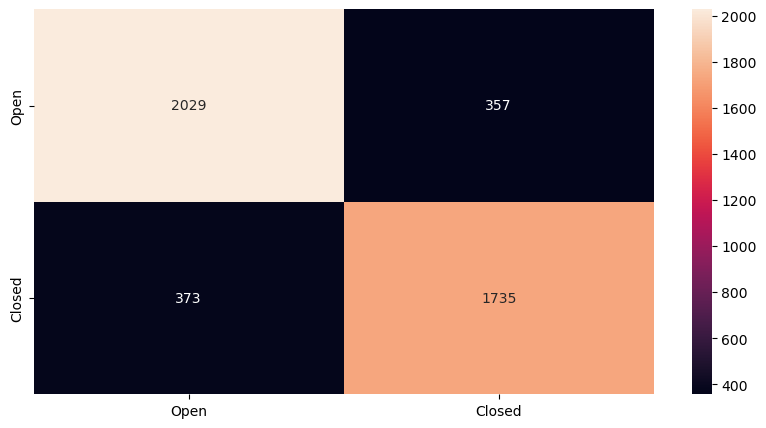

,Open,Closed
Open,2029,357
Closed,373,1735


In [26]:
#using the best 
knn = KNearestNeighbors(k=best_k, distance_measure=euclidean_distance)
knn.fit(X_trn, y_trn)
y_tst_hat_KNN = knn.predict(X_tst)
tst_acc_KNN = accuracy_score(y_tst, y_tst_hat_KNN)
print(f"KNN Test Accuracy: {tst_acc_KNN:.5f}")
classification_rep = classification_report(y_tst, y_tst_hat_KNN)
print(f"\nClassification Report: ", classification_rep)

plot_confusion_matrix(y_tst, y_tst_hat_KNN, class_names={0:"Open", 1:"Closed"})

## Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

### Hyperparameter Tuning

In [28]:
best_n = 0
best_vld_acc = 0
for n in [200, 300, 400, 500]:
    rf = RandomForestClassifier(n_estimators=n, max_features='sqrt', random_state=42)
    rf.fit(X_trn, y_trn)
    preds = rf.predict(X_vld)
    acc = accuracy_score(y_vld, preds)
    print(f"n_estimators: {n}, vld_accuracy: {acc:.5f}")
    if acc > best_vld_acc:
        best_vld_acc = acc
        best_n = n

print(f"Best k: {best_n}, Validation Accuracy: {best_vld_acc:.5f}")

n_estimators: 200, vld_accuracy: 0.91291
n_estimators: 300, vld_accuracy: 0.91418
n_estimators: 400, vld_accuracy: 0.91513
n_estimators: 500, vld_accuracy: 0.91386
Best k: 400, Validation Accuracy: 0.91513


Random Forest Test Accuracy: 0.9159

Classification Report:                precision    recall  f1-score   support

           0       0.90      0.95      0.92      2386
           1       0.94      0.88      0.91      2108

    accuracy                           0.92      4494
   macro avg       0.92      0.91      0.92      4494
weighted avg       0.92      0.92      0.92      4494



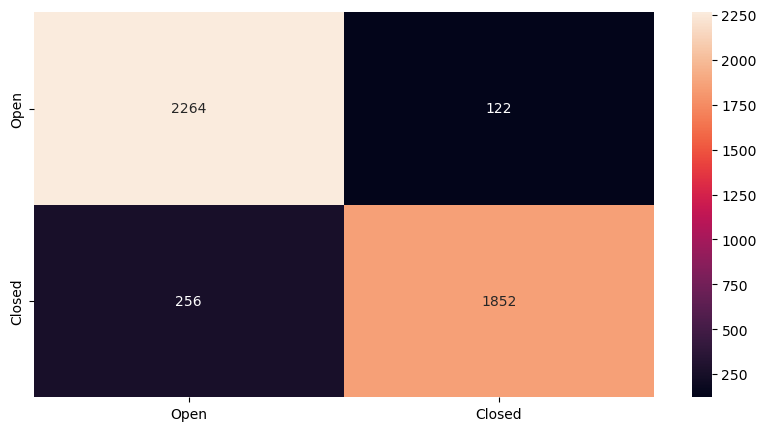

,Open,Closed
Open,2264,122
Closed,256,1852


In [29]:
# Best validation accuracy was at 400 trees
# So we train final model with 400 estimators
rf = RandomForestClassifier(n_estimators=best_n, max_features='sqrt', random_state=42)
rf.fit(X_trn, y_trn)
y_hat_rf = rf.predict(X_tst)
rf_acc = accuracy_score(y_tst, y_hat_rf)
print(f"Random Forest Test Accuracy: {rf_acc:.4f}")
classification_rep = classification_report(y_tst, y_hat_rf)
print(f"\nClassification Report: ", classification_rep)

plot_confusion_matrix(y_tst, y_hat_rf, class_names={0:"Open", 1:"Closed"})


# References

`"EEG Eye State." UCI Machine Learning Repository, 2013, https://doi.org/10.24432/C57G7J.`

# Acknowledgements

`I have used the sklearn.ensemble library for the Random Forest Classification. I have used my own code for KNN and the other functions like preprocessing and data visualization. `